In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle


path = os.getcwd().split(os.sep + 'network')[0]
if path not in sys.path:
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.data as data

    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

In [2]:
def plot_0():

    fig, ax = plt.subplots(2,2, figsize=(12,10))
    ax[0,0].plot(aln.t, aln.rates_exc[0,:], lw=1, c='red', label='Node 0 exc')
    ax[0,1].plot(aln.t, aln.rates_inh[0,:], lw=1, c='blue', label='Node 0 inh')
    ax[1,0].plot(aln.t, aln.rates_exc[1,:], lw=1, c='red', label='Node 1 exc')
    ax[1,1].plot(aln.t, aln.rates_inh[1,:], lw=1, c='blue', label='Node 1 inh')


    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Rate [Hz]")
            ax[i,j].set_xlim(0, aln.t[-1])
    plt.show()


In [65]:
def plot(control0, state0, target):

    fig, ax = plt.subplots(4,2, figsize=(12,14))
    
    print(control0.shape[2], control0.shape[2] * aln.params.dt)
    
    t_array = np.arange(0., round(control0.shape[2] * aln.params.dt, 1), aln.params.dt)
    print(t_array.shape, state0.shape)

    ax[0,0].plot(t_array, state0[0,0,:], lw=1, c='red', label='Node 0 exc')
    ax[0,1].plot(t_array, state0[0,1,:], lw=1, c='blue', label='Node 0 inh')
    ax[1,0].plot(t_array, state0[1,0,:], lw=1, c='red', label='Node 1 exc')
    ax[1,1].plot(t_array, state0[1,1,:], lw=1, c='blue', label='Node 1 inh')

    ax[0,0].plot(t_array, target[0,0,:], linestyle='--', c='red')
    ax[0,1].plot(t_array, target[0,1,:], linestyle='--', c='blue')
    ax[1,0].plot(t_array, target[1,0,:], linestyle='--', c='red')
    ax[1,1].plot(t_array, target[1,1,:], linestyle='--', c='blue')

    ax[2,0].plot(t_array, control0[0,0,:], c='red', label='Node 0 exc')
    ax[2,1].plot(t_array, control0[0,1,:], c='blue', label='Node 0 inh')
    ax[3,0].plot(t_array, control0[1,0,:], c='red', label='Node 1 exc')
    ax[3,1].plot(t_array, control0[1,1,:], c='blue', label='Node 1 inh')

    for i in range(2):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Rate [Hz]")
            ax[i,j].set_xlim(0, aln.params.duration)

    for i in range(2,4):
        for j in range(2):
            ax[i,j].set_xlabel("t [ms]")
            ax[i,j].set_ylabel("Control [nA]")
            ax[i,j].set_xlim(0, aln.params.duration)

    plt.show()
    
def setinit(initvars, N):
    state_vars = aln.state_vars
    init_vars = aln.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                for n in range(N):
                    if aln.params[init_vars[iv]].ndim == 1:
                        aln.params[init_vars[iv]][n] = initvars[n,sv]
                    else:
                        aln.params[init_vars[iv]][n,:] = initvars[n,sv]

In [6]:
def initmodel(mue, mui, cmat, dmat):
    aln = ALNModel(Cmat = cmat, Dmat = dmat)
    aln.params.Dmat = dmat
    
    N = aln.params.N
    aln.params.sigma_ou = 0.
    aln.params.a = 0.
    aln.params.b = 0.

    aln.params.ext_exc_current = 0.
    aln.params.ext_inh_current = 0.

    aln.params.mue_ext_mean = mue * 5.
    aln.params.mui_ext_mean = mui * 5.
    
    aln.params.de = 0.
    aln.params.di = 0.
    
    return aln

In [46]:
cmat = 1. * np.array( [[0., 1.], [1., 0.]] )
dmat = 0. * np.array( [[1., 1.], [1., 1.]] )
aln = initmodel(0., 0., cmat, dmat)
N = aln.params.N

tol = 1e-10
start_step = 10.

max_cntrl = [5., 5., 100., 100., 100., 100.]
min_cntrl = [-5., -5., 0., 0., 0., 0.]

dur_pre = 10.
dur_post = 10.
trans_time = 0.9
n_pre = int(dur_pre / aln.params.dt)
n_post = int(dur_post / aln.params.dt)

c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

### Possible states
1. connetivity (0=>1)

    a) [0.45, 0.475]
        * both low (0.0002 22.3545, 0.0002 22.3545)
        * both high (35.6907 90.3982, 38.372 90.9708)
        * 0 low, 1 high (0.0002 22.3545, 35.6907 90.3982)

    b) [0.475, 0.6]
        * both low (0.0 41.9181, 0.0 41.9181)
        * both high (39.9286 107.7591, 42.2686 108.1481)
        * 0 low, 1 high (0.0 41.9181, 39.9286 107.7591

1. connetivity (0=>1, 1=>0)

    a) [0.45, 0.475]
        * both low (0.0002 22.3546, 0.0002 22.3546)
        * both high (38.5174 90.9999, 38.5174 90.9999)

    b) [0.475, 0.6]
        * both low (0.0 41.9181, 0.0 41.9181)
        * both high (42.3692 108.164, 42.3692 108.164)

### Scenarios

1. connetivity (0=>1)
    * measure target in 1:
        - low, low => high, high
        - high, high => low, low
        - low, low => low, high
        - high, high => low, high
        - low, high => high, high
        - low, high => low, low
    * measure target in (0,1):
        - low, low => high, high
        - high, high => low, low
        - low, low => low, high
        - high, high => low, high
        - low, high => high, high
        - low, high => low, low
2. connectivity (0=>1, 1=>0)
    * measure target in 1:
        - low, low => high, high
        - high, high => low, low
    * measure target in (0,1):
        - low, low => high, high
        - high, high => low, low

In [47]:
mu_ext = [[0.45, 0.475], [0.475, 0.6]]
cmat_array = [ np.array( [[0., 0.], [1., 0.]] ), np.array( [[0., 1.], [1., 0.]] ) ]
c_var = np.array([[1,1,0,0,0,0],[1,1,0,0,0,0]])

p_var_array = np.array( [ [[0,0],[1,0]], [[1,0],[1,0]] ] )

dur = 200.
file_ = '2node.pickle'

target_array = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]
               
init_vars_array = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]

optControl = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]

optState = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]

weight = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]

costnode = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]

w_init = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ],
                 [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                   [ [ None, None ], [ None, None ] ] ] ]

cost_uncontrolled = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                           [ [ None, None ], [ None, None ] ] ],
                      [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                           [ [ None, None ], [ None, None ] ] ] ]

               
state_vars = aln.state_vars
init_vars = aln.init_vars

In [32]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    optControl = load_array[0]
    optState = load_array[1]
    weight = load_array[2]
    costnode = load_array[3]
    w_init = load_array[4]

file found


In [48]:
for m_ind in range(len(mu_ext)):
    print("POINT : ", mu_ext[m_ind])
    
    for c_ind in range(len(cmat_array)):
        print("CONNECTIVITY : ", cmat_array[c_ind])
        cmat = cmat_array[c_ind]
        
        for p_ind in range(len(p_var_array)):
            print("PRECISION MEASURE : ", p_var_array[p_ind])

            aln = initmodel(mu_ext[m_ind][0], mu_ext[m_ind][1], cmat, dmat)

            print("low low")

            aln.params.duration = 10000.
            control0 = aln.getZeroControl()
            control0[0,0,30000:32000] = -5.
            #control0[0,0,70000:72000] = 1.
            control0[1,0,30000:32000] = -5.
            #control0[1,0,70000:72000] = 5.
            aln.run( control = control0 )

            #plot(control0)

            aln.params.duration = dur
            target = aln.getZeroTarget()
            target[0,0,:] = np.mean(aln.rates_exc[0,-100:])
            target[1,0,:] = np.mean(aln.rates_exc[1,-100:])
            target[0,1,:] = np.mean(aln.rates_inh[0,-100:])
            target[1,1,:] = np.mean(aln.rates_inh[1,-100:])

            init_state_vars = np.zeros(( N, len(state_vars) ))
            for n in range(N):
                for j in range(len(state_vars)):
                    if aln.state[state_vars[j]][n].size == 1:
                        init_state_vars[n, j] = aln.state[state_vars[j]][n]
                    else:
                        init_state_vars[n, j] = aln.state[state_vars[j]][n,-1]

            target_array[m_ind][c_ind][p_ind][1] = target
            init_vars_array[m_ind][c_ind][p_ind][0] = init_state_vars
            
            if c_ind == 0:
                target_array[m_ind][c_ind][p_ind][5] = target
                init_vars_array[m_ind][c_ind][p_ind][2] = init_state_vars

            print("high high")

            aln.params.duration = 10000.
            control0 = aln.getZeroControl()
            #control0[0,0,30000:32000] = -5.
            control0[0,0,70000:72000] = 5.
            #control0[1,0,30000:32000] = -5.
            control0[1,0,70000:72000] = 5.
            aln.run( control = control0 )

            #plot(control0)

            aln.params.duration = dur
            target = aln.getZeroTarget()
            target[0,0,:] = np.mean(aln.rates_exc[0,-100:])
            target[1,0,:] = np.mean(aln.rates_exc[1,-100:])
            target[0,1,:] = np.mean(aln.rates_inh[0,-100:])
            target[1,1,:] = np.mean(aln.rates_inh[1,-100:])

            init_state_vars = np.zeros(( N, len(state_vars) ))
            for n in range(N):
                for j in range(len(state_vars)):
                    if aln.state[state_vars[j]][n].size == 1:
                        init_state_vars[n, j] = aln.state[state_vars[j]][n]
                    else:
                        init_state_vars[n, j] = aln.state[state_vars[j]][n,-1]

            target_array[m_ind][c_ind][p_ind][0] = target
            init_vars_array[m_ind][c_ind][p_ind][1] = init_state_vars
            
            if c_ind == 0:
                target_array[m_ind][c_ind][p_ind][4] = target
                init_vars_array[m_ind][c_ind][p_ind][3] = init_state_vars
                
            if c_ind == 1:
                continue

            print("low high")

            aln.params.duration = 10000.
            control0 = aln.getZeroControl()
            control0[0,0,30000:32000] = -5.
            #control0[0,0,70000:72000] = 5.
            control0[1,0,30000:32000] = -5.
            control0[1,0,70000:72000] = 5.
            aln.run( control = control0 )

            #plot(control0)

            aln.params.duration = dur
            target = aln.getZeroTarget()
            target[0,0,:] = np.mean(aln.rates_exc[0,-100:])
            target[1,0,:] = np.mean(aln.rates_exc[1,-100:])
            target[0,1,:] = np.mean(aln.rates_inh[0,-100:])
            target[1,1,:] = np.mean(aln.rates_inh[1,-100:])

            init_state_vars = np.zeros(( N, len(state_vars) ))
            for n in range(N):
                for j in range(len(state_vars)):
                    if aln.state[state_vars[j]][n].size == 1:
                        init_state_vars[n, j] = aln.state[state_vars[j]][n]
                    else:
                        init_state_vars[n, j] = aln.state[state_vars[j]][n,-1]

            target_array[m_ind][c_ind][p_ind][2] = target
            target_array[m_ind][c_ind][p_ind][3] = target

            init_vars_array[m_ind][c_ind][p_ind][4] = init_state_vars
            init_vars_array[m_ind][c_ind][p_ind][5] = init_state_vars

POINT :  [0.45, 0.475]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
low low
high high
low high
PRECISION MEASURE :  [[1 0]
 [1 0]]
low low
high high
low high
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
low low
high high
PRECISION MEASURE :  [[1 0]
 [1 0]]
low low
high high
POINT :  [0.475, 0.6]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
low low
high high
low high
PRECISION MEASURE :  [[1 0]
 [1 0]]
low low
high high
low high
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
low low
high high
PRECISION MEASURE :  [[1 0]
 [1 0]]
low low
high high


In [49]:
# get uncontrolled cost
cgv = None

for m_ind in range(len(mu_ext)):
    print("POINT : ", mu_ext[m_ind])
    
    for c_ind in range(len(cmat_array)):
        print("CONNECTIVITY : ", cmat_array[c_ind])
        cmat = cmat_array[c_ind]
        
        for p_ind in range(len(p_var_array)):
            print("PRECISION MEASURE : ", p_var_array[p_ind])
            
            for t_ind in range(6):
                print("TASK : ", t_ind)
                if c_ind == 1 and t_ind > 1:
                    continue
                    
                aln = initmodel(mu_ext[m_ind][0], mu_ext[m_ind][1], cmat, dmat)
                    
                aln.params.duration = dur
                cost.setParams(1.0, 0.0, 0.0)
                setinit(init_vars_array[m_ind][c_ind][p_ind][t_ind], N)
                control0 = aln.getZeroControl()

                max_it = 0

                bestControl_init_, bestState_init_, cost_init_, r_, g_, p_, costnode_init_ = aln.A1(
                    control0, target_array[m_ind][c_ind][p_ind][t_ind], c_scheme, u_mat, u_scheme,
                        max_iteration_ = max_it, tolerance_ = tol, startStep_ = start_step,
                        max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
                        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
                        prec_variables_ = p_var_array[p_ind], transition_time_ = trans_time)

                cost_uncontrolled[m_ind][c_ind][p_ind][t_ind] = cost_init_[0]

POINT :  [0.45, 0.475]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  146580.5207689106
Gradient descend method:  None
RUN  0 , total integrated cost =  146580.5207689106
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0
TASK :  1
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  146580.52076891062
Gradient descend method:  None
RUN  0 , total integrated cost =  146580.52076891062
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0
TASK :  2
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  126810.96329942998
Gradient descend method:  None
RUN  0 , total integrated cost =  126810.96329942998
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0

RUN  0 , total integrated cost =  158715.69224137545
Gradient descend method:  None
RUN  0 , total integrated cost =  158715.69224137545
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  178710.92302190745
Gradient descend method:  None
RUN  0 , total integrated cost =  178710.92302190745
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0
TASK :  1
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  178710.92302190745
Gradient descend method:  None
RUN  0 , total integrated cost =  178710.92302190745
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
set cost par

In [40]:
optControl[0][0][1][3] = None

POINT :  [0.45, 0.475]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
set cost params:  1.0 0.0 10000.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  127526.52869245864
Gradient descend method:  None
RUN  1 , total integrated cost =  31062.420379344963
RUN  2 , total integrated cost =  25670.814481334666
RUN  3 , total integrated cost =  21572.302261203004
RUN  3 , total integrated cost =  21572.302261203004
Improved over  3  iterations in  91.59516291401815  seconds by  83.08406691346042  percent.
Final step size =  0.0006103515625
0.1691593308653958
3
set cost params:  1.0 0.0 90000.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  127526.52869245864
Gradient descend method:  None
RUN  1 , total integrated cost =  127526.52869245864
Control only changes marginally.
RUN  1 , tot

ValueError: x and y must have same first dimension, but have shapes (101,) and (2201,)

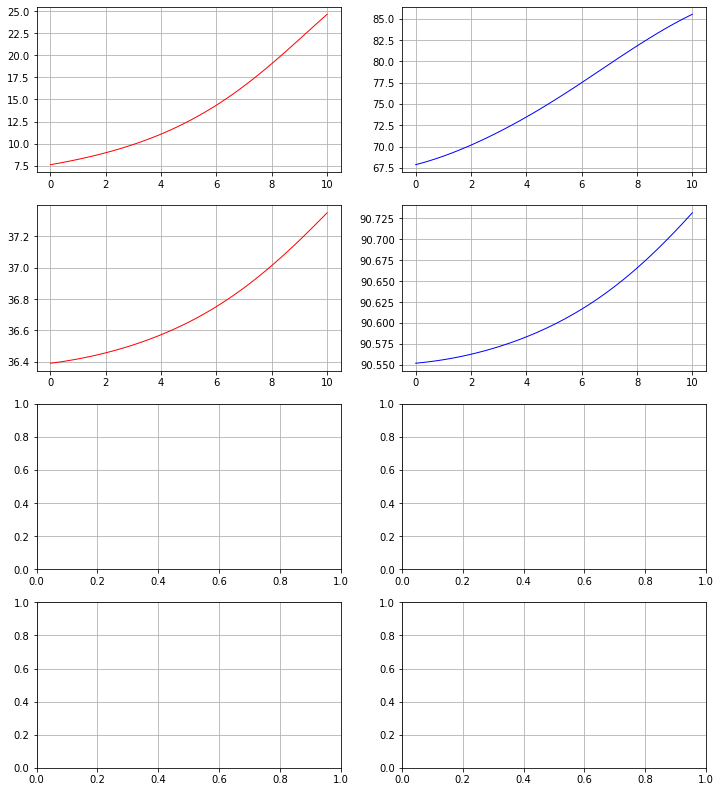

In [50]:
cgv = None
factor_we = 0.
factor_ws = 1.
cost_index = 2

for m_ind in range(len(mu_ext)):
    print("POINT : ", mu_ext[m_ind])
    
    for c_ind in range(len(cmat_array)):
        print("CONNECTIVITY : ", cmat_array[c_ind])
        cmat = cmat_array[c_ind]
        
        for p_ind in range(len(p_var_array)):
            print("PRECISION MEASURE : ", p_var_array[p_ind])
            
            for t_ind in range(6):
                print("TASK : ", t_ind)
                
                if c_ind == 1 and t_ind > 1:
                    continue
                    
                if [m_ind, c_ind, p_ind, t_ind] != [0,0,1,3]:
                    continue

                aln = initmodel(mu_ext[m_ind][0], mu_ext[m_ind][1], cmat, dmat)

                if type(optControl[m_ind][c_ind][p_ind][t_ind]) != type(None):
                    print("done")
                    continue

                found_exponent = False
                found_digit_0 = False
                found_digit_1 = False
                exponent = 4
                sig_digit = [1., 0.]

                while not found_digit_1:
                    
                    if exponent < -10:
                        continue

                    w_init[m_ind][c_ind][p_ind][t_ind] = (sig_digit[0] * 10**exponent
                                                          + sig_digit[1] * 10**(exponent-1.) )

                    aln.params.duration = dur
                    setinit(init_vars_array[m_ind][c_ind][p_ind][t_ind], N)
                    control0 = aln.getZeroControl()
                    cost.setParams(1., factor_we * w_init[m_ind][c_ind][p_ind][t_ind],
                                   factor_ws * w_init[m_ind][c_ind][p_ind][t_ind])
                    max_it = int(3)
                    if found_digit_0:
                        max_it = int(6)

                    optControl[m_ind][c_ind][p_ind][t_ind], optState[m_ind][c_ind][p_ind][t_ind], c_, r_, g_, p_, costnode[m_ind][c_ind][p_ind][t_ind] = aln.A1(
                        control0, target_array[m_ind][c_ind][p_ind][t_ind], c_scheme, u_mat, u_scheme,
                        max_iteration_ = max_it, tolerance_ = tol, startStep_ = start_step,
                        max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
                        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
                        prec_variables_ = p_var_array[p_ind], transition_time_ = trans_time)
                    
                    print(c_[-1]/cost_uncontrolled[m_ind][c_ind][p_ind][t_ind])

                    if found_exponent == False and c_[-1] == 0.:
                        print("1")
                        exponent -= 1
                        continue
                    elif ( found_exponent == False and found_digit_0 == False
                          and c_[-1]/cost_uncontrolled[m_ind][c_ind][p_ind][t_ind] > 0.8):
                        print("2")
                        exponent -= 1
                        continue
                    elif found_exponent == False and found_digit_0 == False:
                        print("3")
                        found_exponent = True
                        sig_digit[0] = 9.
                    elif found_exponent == True and found_digit_0 == False and c_[-1] == 0.:
                        print("4")
                        sig_digit[0] -= 1.
                        continue
                    elif (found_exponent == True and found_digit_0 == False
                         and c_[-1]/cost_uncontrolled[m_ind][c_ind][p_ind][t_ind] > 0.8):
                        print("5")
                        sig_digit[0] -= 1.
                        continue
                    elif found_exponent == True and found_digit_0 == False:
                        print("6")
                        found_digit_0 = True
                        sig_digit[1] = 9.
                        continue
                    elif (found_exponent == True and found_digit_0 == True
                          and found_digit_1 == False and c_[-1] == 0.):
                        print("7")
                        sig_digit[1] -= 1.
                        continue
                    elif (found_exponent == True and found_digit_0 == True and found_digit_1 == False 
                          and c_[-1]/cost_uncontrolled[m_ind][c_ind][p_ind][t_ind] > 0.8):
                        print("8")
                        sig_digit[1] -= 1.
                        continue
                    elif found_exponent == True and found_digit_0 == True and found_digit_1 == False:
                        print("weight = ", w_init[m_ind][c_ind][p_ind][t_ind])

                        if True:
                            plot(optControl[m_ind][c_ind][p_ind][t_ind][:,:,100:-100])

                        with open(file_,'wb') as f:
                            pickle.dump([optControl, optState, weight, costnode, w_init], f)

                        print('uncontrolled cost : ', cost_uncontrolled[m_ind][c_ind][p_ind][t_ind])
                        print('cost splitting : ', costnode[m_ind][c_ind][p_ind][t_ind][0][0][0],
                              costnode[m_ind][c_ind][p_ind][t_ind][cost_index][0][2:])    

                        break    

In [88]:
plot(optControl[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             optState[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             target_array[m_ind][c_ind][p_ind][t_ind])

IndexError: list index out of range

POINT :  [0.45, 0.475]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
--------------- k  0
set cost params:  1.0 0.0 58000.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  97593.63916409097
Gradient descend method:  None
RUN  1 , total integrated cost =  97486.06492247958
RUN  2 , total integrated cost =  97386.28518397897
RUN  3 , total integrated cost =  97363.10054379569
RUN  4 , total integrated cost =  97332.1662320222
RUN  5 , total integrated cost =  97320.59947480228
RUN  6 , total integrated cost =  97301.64886206145
RUN  7 , total integrated cost =  97285.70400380914
RUN  8 , total integrated cost =  96960.10916405107
RUN  9 , total integrated cost =  96829.89839063292
RUN  10 , total integrated cost =  96822.01197487253
RUN  11 , total integrated cost =  96805.93568928729
RUN  12 , total integ

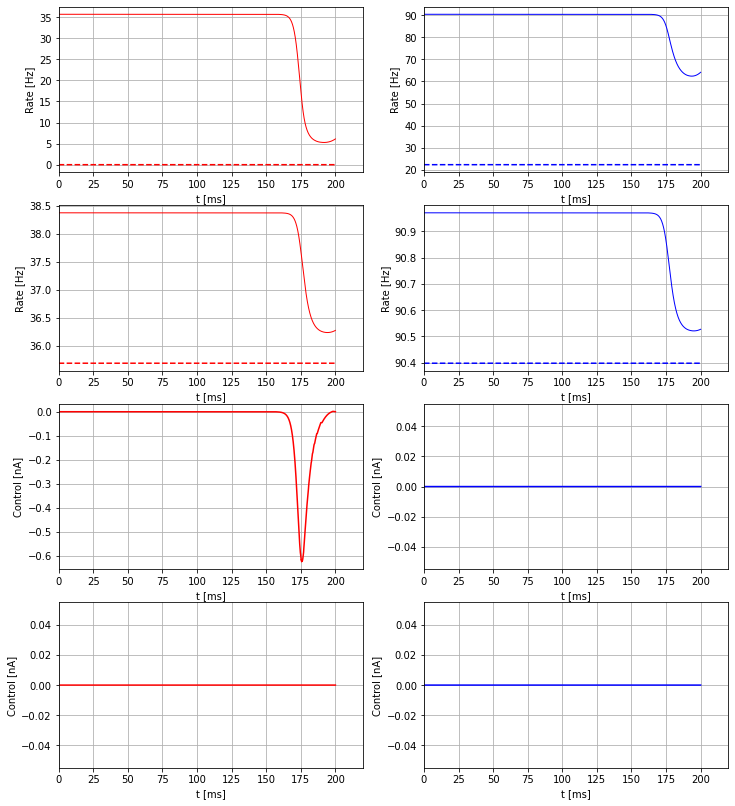

--------------- k  1
set cost params:  1.0 0.0 59947.76442253538
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  99434.15443604733
Gradient descend method:  None
RUN  1 , total integrated cost =  99313.76847697837
RUN  2 , total integrated cost =  99045.49966086529
RUN  3 , total integrated cost =  98896.94479502467
RUN  4 , total integrated cost =  98692.93182577765
RUN  5 , total integrated cost =  98664.6450437419
RUN  6 , total integrated cost =  98664.17406648418
RUN  7 , total integrated cost =  98663.4663546142
RUN  8 , total integrated cost =  98659.54279906167
RUN  9 , total integrated cost =  98658.57031013975
RUN  10 , total integrated cost =  98658.14561185642
RUN  11 , total integrated cost =  98642.52198324083
RUN  12 , total integrated cost =  98632.06523142799
RUN  13 , total integrated cost =  98631.83540963082
RUN  14 , total integrated cost =  98618.65330131791
RUN  15 , total integrated cost =  98602.72895214203
RUN  16 , total integrated cos

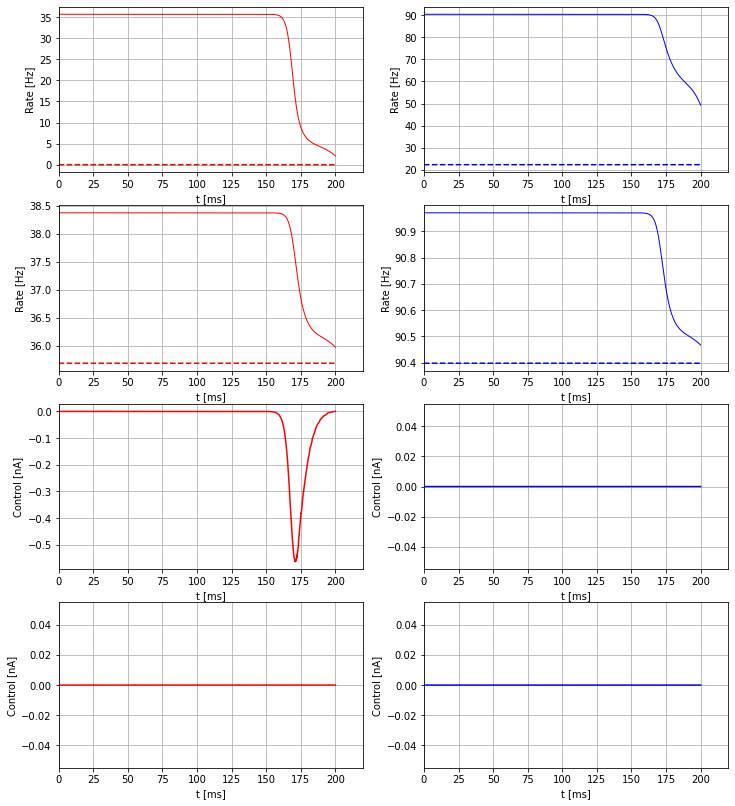

--------------- k  2
set cost params:  1.0 0.0 62098.8147476678
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  101260.08626833378
Gradient descend method:  None
RUN  1 , total integrated cost =  101257.25493536938
RUN  2 , total integrated cost =  101251.49652108205
RUN  3 , total integrated cost =  101250.77475366183
RUN  4 , total integrated cost =  101246.84349364064
RUN  5 , total integrated cost =  101239.70815621417
RUN  6 , total integrated cost =  101239.21611766987
RUN  7 , total integrated cost =  101234.18705327607
RUN  8 , total integrated cost =  101225.81115828046
RUN  9 , total integrated cost =  101225.38762960318
RUN  10 , total integrated cost =  101224.76957809305
RUN  11 , total integrated cost =  101221.43944480288
RUN  12 , total integrated cost =  101220.37426682858
RUN  13 , total integrated cost =  101220.14367335223
RUN  14 , total integrated cost =  101176.26206066916
RUN  15 , total integrated cost =  101165.35544752242
RUN  16 , tot

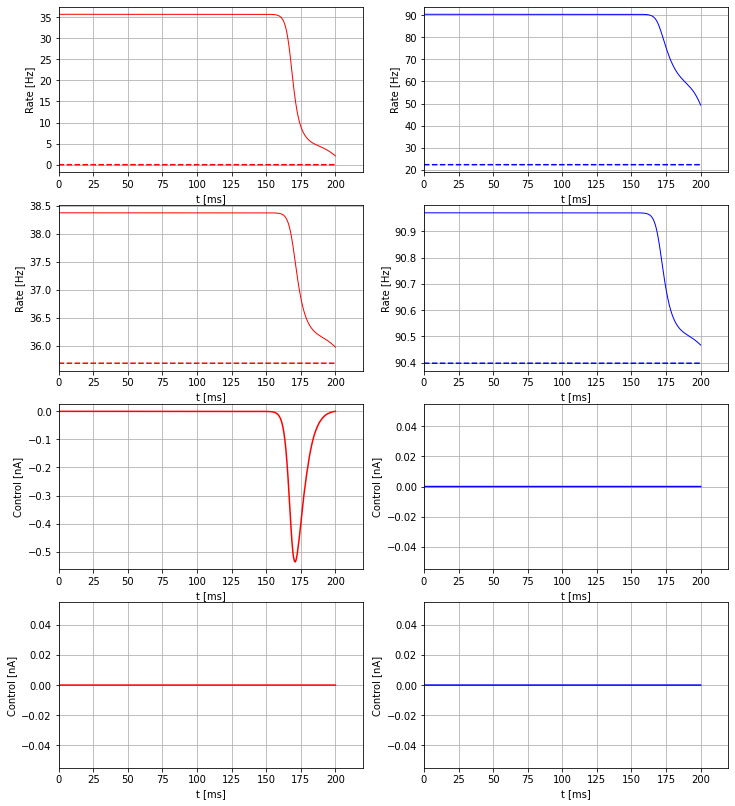

--------------- k  3
set cost params:  1.0 0.0 64171.852016393415
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  104482.53659709476
Gradient descend method:  None
RUN  1 , total integrated cost =  104480.99121180964
RUN  2 , total integrated cost =  104480.82354598439
RUN  3 , total integrated cost =  104480.82093255535
RUN  4 , total integrated cost =  104480.8208220722
Control only changes marginally.
RUN  4 , total integrated cost =  104480.8208220722
Improved over  4  iterations in  106.94605327502359  seconds by  0.0016421644022557302  percent.
Final step size =  3.725290298461914e-08
cost splitting :  1806.5474390003658 [1.59960882 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


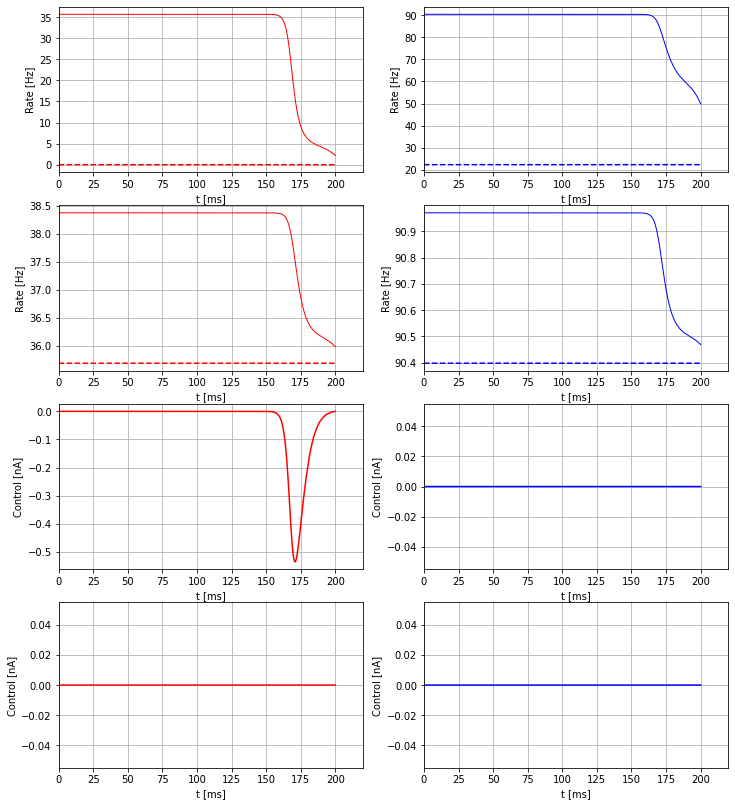

--------------- k  4
set cost params:  1.0 0.0 66231.54302006721
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  107775.52072576298
Gradient descend method:  None
RUN  1 , total integrated cost =  107773.82156928122
RUN  2 , total integrated cost =  107773.56161035287
RUN  3 , total integrated cost =  107773.55746866616
RUN  4 , total integrated cost =  107773.55740966456
RUN  5 , total integrated cost =  107773.55739061323
Control only changes marginally.
RUN  5 , total integrated cost =  107773.55739061323
Improved over  5  iterations in  133.1990322729689  seconds by  0.0018216893191720374  percent.
Final step size =  3.725290298461914e-08
cost splitting :  1834.0998324015452 [1.59915951 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


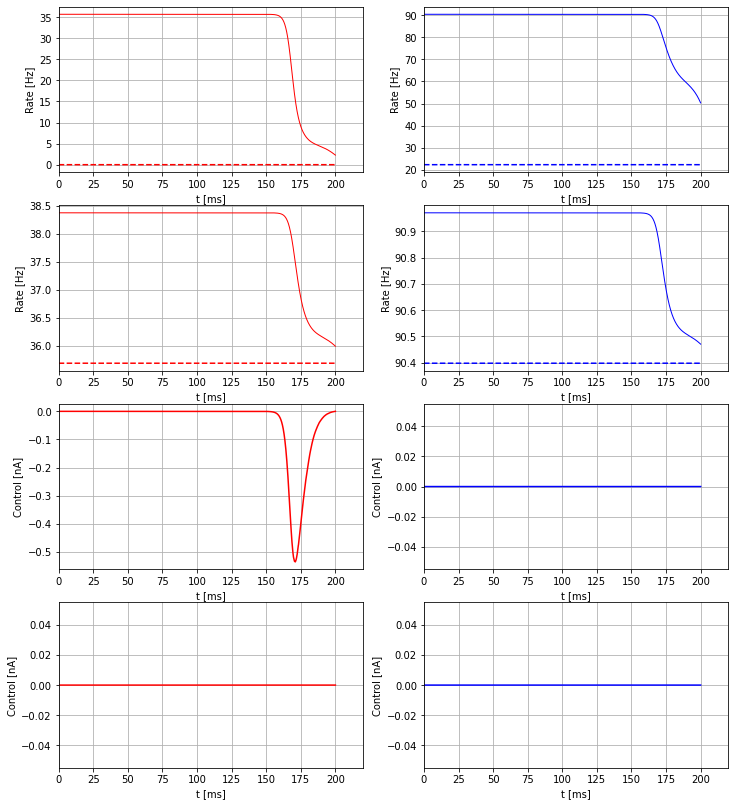

--------------- k  5
set cost params:  1.0 0.0 68291.77511222786
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  111068.19712743568
Gradient descend method:  None
RUN  1 , total integrated cost =  111066.6937812631
RUN  2 , total integrated cost =  111066.51294923162
RUN  3 , total integrated cost =  111066.50851300896
RUN  4 , total integrated cost =  111066.50800615079
RUN  5 , total integrated cost =  111066.50799230748
Control only changes marginally.
RUN  5 , total integrated cost =  111066.50799230748
Improved over  5  iterations in  139.46204771200428  seconds by  0.0015208089911311617  percent.
Final step size =  2.9103830456733704e-10
cost splitting :  1862.6911848298244 [1.59871053 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


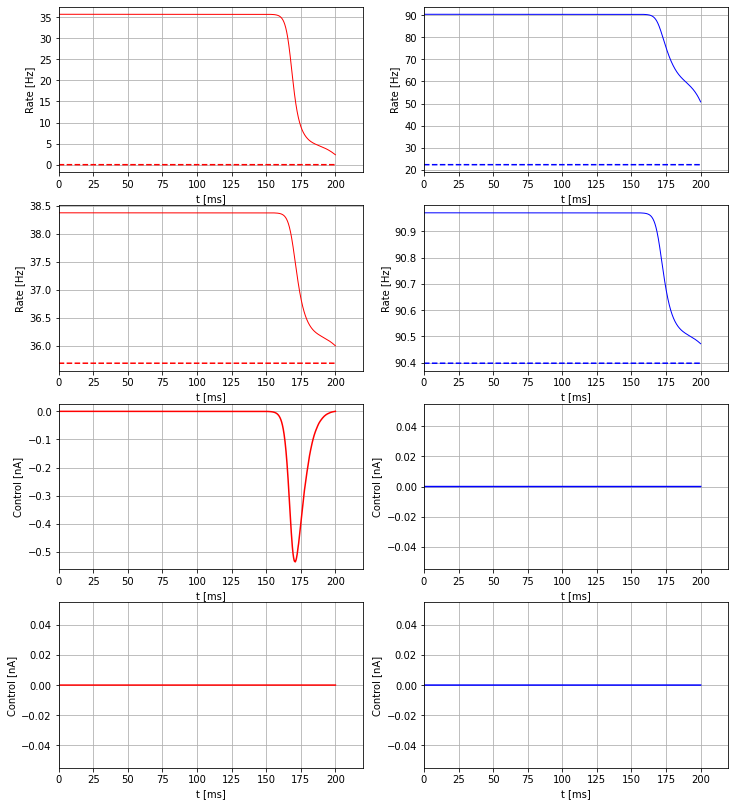

--------------- k  6
set cost params:  1.0 0.0 70352.54402925313
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  114361.08096604406
Gradient descend method:  None
RUN  1 , total integrated cost =  114359.62237685587
RUN  2 , total integrated cost =  114359.38688089981
RUN  3 , total integrated cost =  114359.38353037027
RUN  4 , total integrated cost =  114359.38244116252
RUN  5 , total integrated cost =  114359.3820031509
RUN  6 , total integrated cost =  114359.38200315088
Control only changes marginally.
RUN  6 , total integrated cost =  114359.38200315088
Improved over  6  iterations in  194.19374244695064  seconds by  0.001485612831586991  percent.
Final step size =  2.9103830456733704e-10
cost splitting :  1889.425572874191 [1.59830268 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


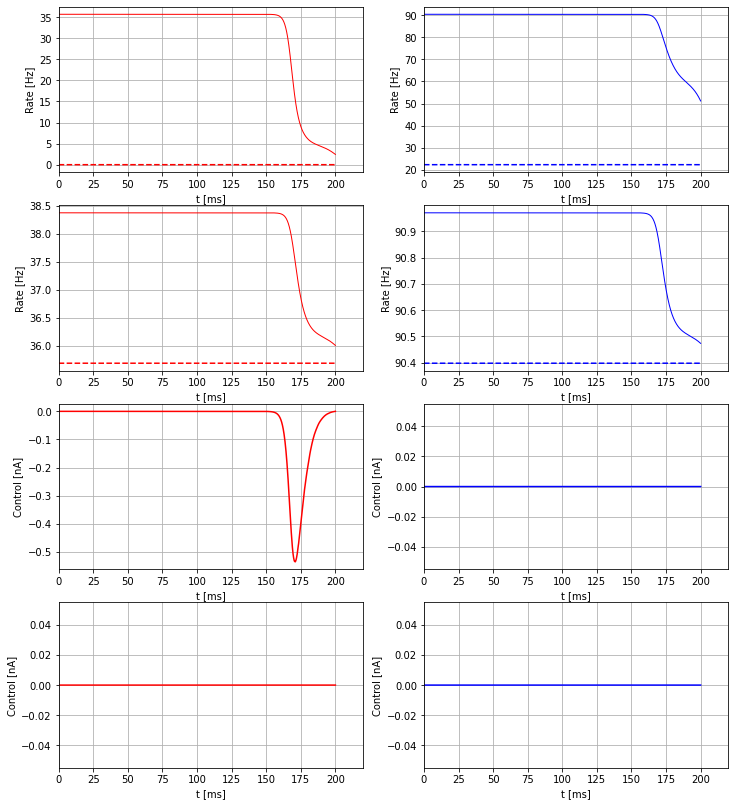

--------------- k  7
set cost params:  1.0 0.0 72413.52499020378
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  117653.45340402493
Gradient descend method:  None
RUN  1 , total integrated cost =  117651.95395130671
RUN  2 , total integrated cost =  117651.77754666263
RUN  3 , total integrated cost =  117651.77336178595
RUN  4 , total integrated cost =  117651.77327873655
RUN  5 , total integrated cost =  117651.77327645528
Control only changes marginally.
RUN  5 , total integrated cost =  117651.77327645528
Improved over  5  iterations in  150.1786260289955  seconds by  0.0014280308151057852  percent.
Final step size =  2.9103830456733704e-10
cost splitting :  1921.0613582968426 [1.5978388 0.       ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


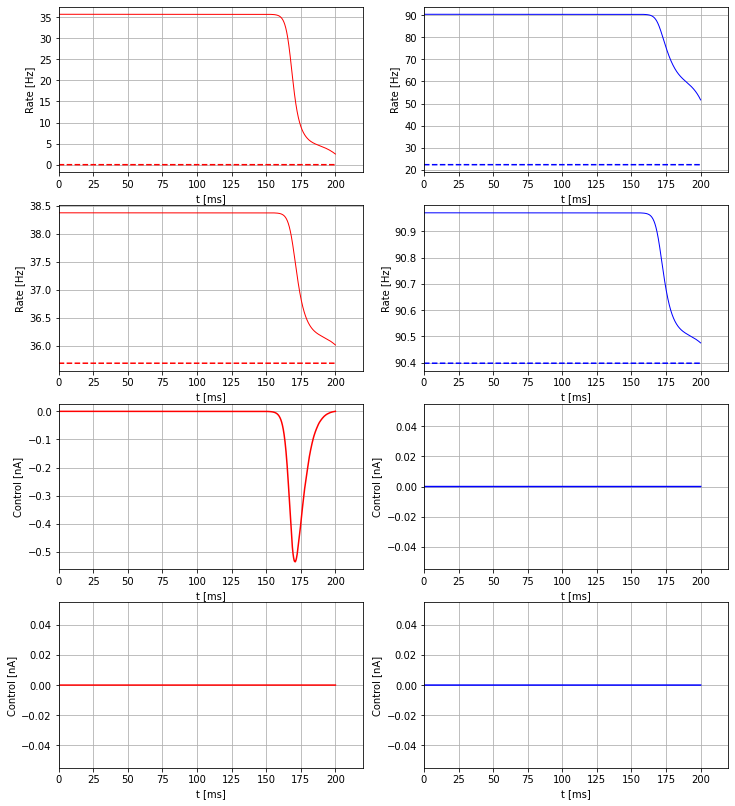

--------------- k  8
set cost params:  1.0 0.0 74474.87241223696
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  120945.47416306542
Gradient descend method:  None
RUN  1 , total integrated cost =  120943.13833368082
RUN  2 , total integrated cost =  120942.46905668148
RUN  3 , total integrated cost =  120942.46615673884
RUN  4 , total integrated cost =  120942.46614146806
Control only changes marginally.
RUN  4 , total integrated cost =  120942.46614146806
Improved over  4  iterations in  136.35271810600534  seconds by  0.0024870890111117205  percent.
Final step size =  3.725290298461914e-08
cost splitting :  1946.3427426167807 [1.59745711 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


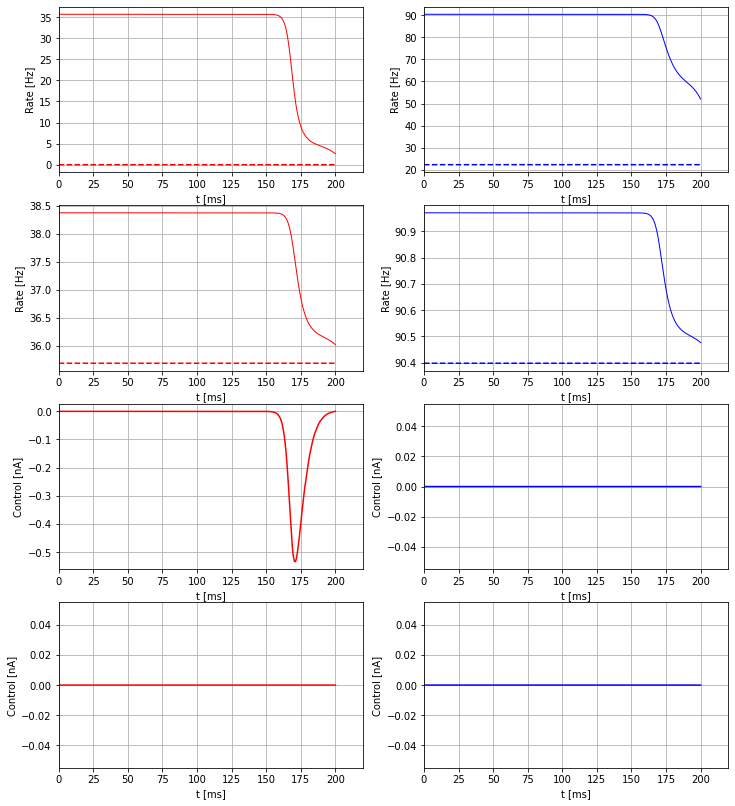

--------------- k  9
set cost params:  1.0 0.0 76536.76340391871
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  124236.24856031511
Gradient descend method:  None
RUN  1 , total integrated cost =  124234.50657237359
RUN  2 , total integrated cost =  124234.20045134914
RUN  3 , total integrated cost =  124234.19713363795
RUN  4 , total integrated cost =  124234.1970103148
Control only changes marginally.
RUN  4 , total integrated cost =  124234.1970103148
Improved over  4  iterations in  126.58729205402778  seconds by  0.001651329643394206  percent.
Final step size =  3.725290298461914e-08
cost splitting :  1977.5257105306891 [1.59701974 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


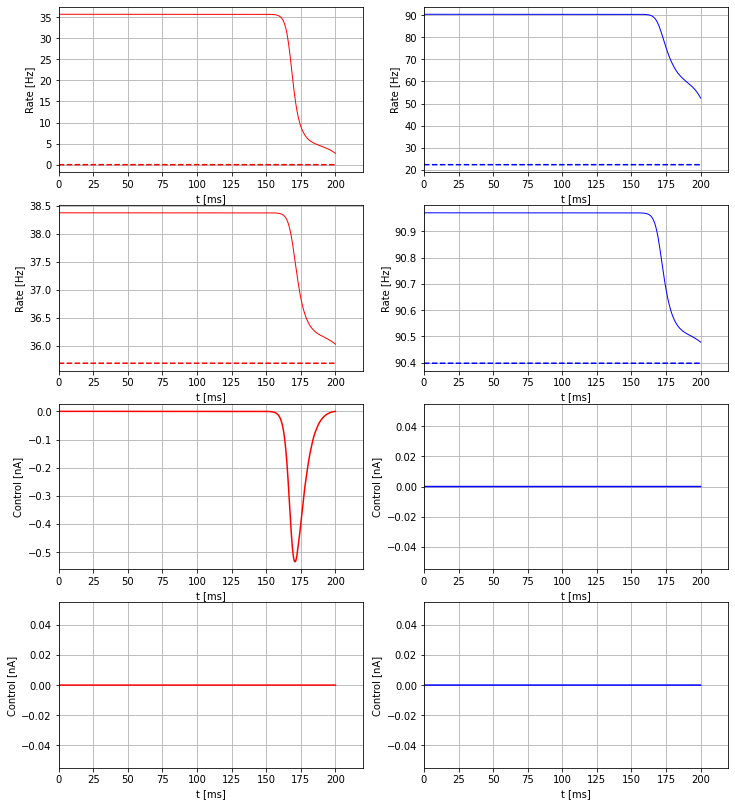

--------------- k  10
set cost params:  1.0 0.0 78598.23084024253
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  127526.40120920603
Gradient descend method:  None
RUN  1 , total integrated cost =  127524.4333994291
RUN  2 , total integrated cost =  127523.95490032095
RUN  3 , total integrated cost =  127523.95089026856
RUN  4 , total integrated cost =  127523.95089026849
Control only changes marginally.
RUN  4 , total integrated cost =  127523.95089026849
Improved over  4  iterations in  120.27494639600627  seconds by  0.001921420909170024  percent.
Final step size =  3.725290298461914e-08
cost splitting :  2004.951858184033 [1.59663495 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


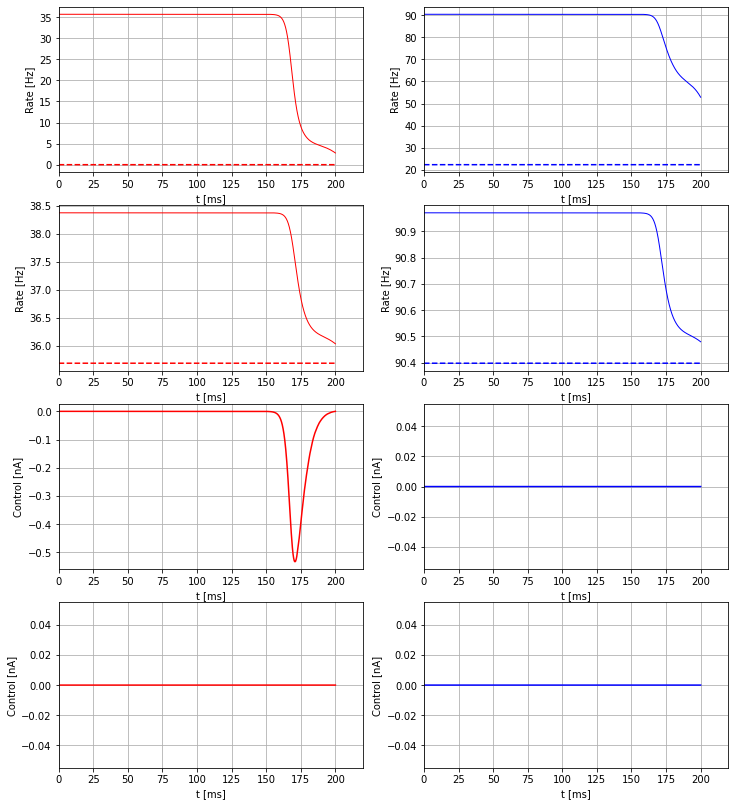

--------------- k  11
set cost params:  1.0 0.0 78599.84536217511
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  127526.52869242111
Gradient descend method:  None
RUN  1 , total integrated cost =  127526.528692421
Control only changes marginally.
RUN  1 , total integrated cost =  127526.528692421
Improved over  1  iterations in  42.86957232799614  seconds by  8.526512829121202e-14  percent.
Final step size =  0.078125
cost splitting :  2004.9518581468126 [1.59663495 0.        ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


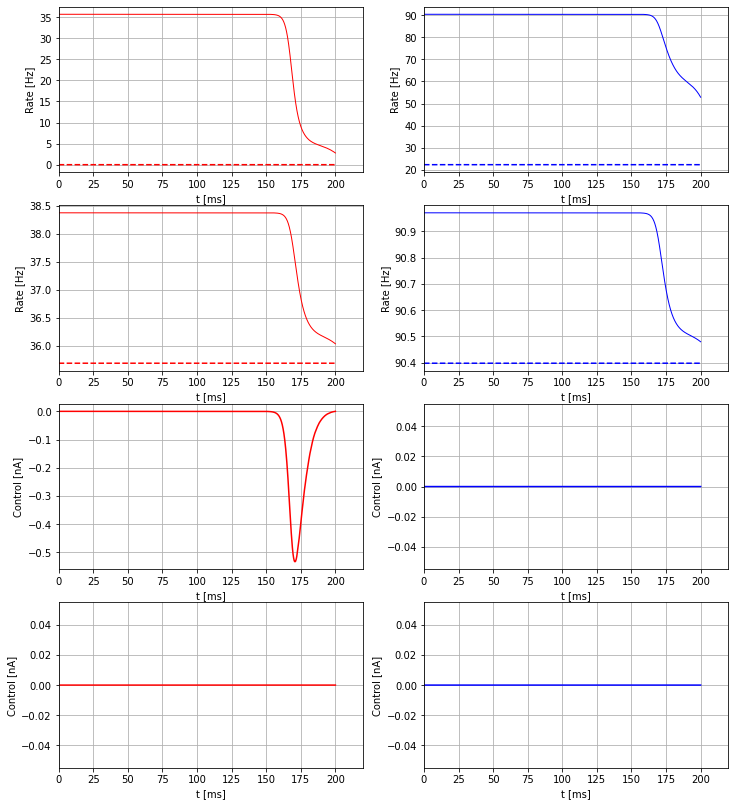

TASK :  4
TASK :  5
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
POINT :  [0.475, 0.6]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5


In [67]:
tol = 1e-6

conv = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                           [ [ None, None ], [ None, None ] ] ],
                      [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                           [ [ None, None ], [ None, None ] ] ] ]

for m_ind in range(len(mu_ext)):
    print("POINT : ", mu_ext[m_ind])
    
    for c_ind in range(len(cmat_array)):
        print("CONNECTIVITY : ", cmat_array[c_ind])
        cmat = cmat_array[c_ind]
        
        for p_ind in range(len(p_var_array)):
            print("PRECISION MEASURE : ", p_var_array[p_ind])
            
            for t_ind in range(6):
                print("TASK : ", t_ind)
                
                if [m_ind, c_ind, p_ind, t_ind] != [0,0,1,3]:
                    continue
                
                if c_ind == 1 and t_ind > 1:
                    continue

                aln = initmodel(mu_ext[m_ind][0], mu_ext[m_ind][1], cmat, dmat)
    
                k = 0

                while not conv[m_ind][c_ind][p_ind][t_ind]:
                    print('--------------- k ', k)
                    max_it = min(500, int(50*k))

                    if k == 0:
                        max_it = 20
                        w_ = w_init[m_ind][c_ind][p_ind][t_ind]
                    else:
                        sum_cost = 0.
                        for n in range(N):
                            sum_cost += sum( costnode[m_ind][c_ind][p_ind][t_ind][cost_index][n][:] )
                        sum_prec = costnode[m_ind][c_ind][p_ind][t_ind][0][1][0]
                        if p_ind == 1:
                            sum_prec += costnode[m_ind][c_ind][p_ind][t_ind][0][0][0]
                        w_ = ( cost_uncontrolled[m_ind][c_ind][p_ind][t_ind]
                                   - sum_prec ) / sum_cost
                        if k < 10:
                            w_ = w_init[m_ind][c_ind][p_ind][t_ind] + 0.1 * k * (w_ - w_init[m_ind][c_ind][p_ind][t_ind])

                    aln.params.duration = dur
                    cost.setParams(1., w_ * factor_we, w_ * factor_ws)
                    weight[m_ind][c_ind][p_ind][t_ind] = cost.getParams()

                    setinit(init_vars_array[m_ind][c_ind][p_ind][t_ind], N)

                    control0 = aln.getZeroControl()
                    control0 = optControl[m_ind][c_ind][p_ind][t_ind][:,:,100:-100]

                    optControl[m_ind][c_ind][p_ind][t_ind], optState[m_ind][c_ind][p_ind][t_ind], c_, r_, g_, p_, costnode[m_ind][c_ind][p_ind][t_ind] = aln.A1(
                        control0, target_array[m_ind][c_ind][p_ind][t_ind], c_scheme, u_mat, u_scheme,
                        max_iteration_ = max_it, tolerance_ = tol, startStep_ = start_step,
                        max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
                        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
                        prec_variables_ = p_var_array[p_ind], transition_time_ = trans_time)

                    if c_[2] == 0.:
                        if k > 10:
                            conv[m_ind][c_ind][p_ind][t_ind] = True

                    #print('uncontrolled cost : ', cost_uncontrolled[i])
                    print('cost splitting : ', costnode[m_ind][c_ind][p_ind][t_ind][0][0][0],
                          costnode[m_ind][c_ind][p_ind][t_ind][cost_index][0][:2])

                    if conv[m_ind][c_ind][p_ind][t_ind] or True:
                        plot(optControl[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             optState[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             target_array[m_ind][c_ind][p_ind][t_ind])

                    if np.abs(target_array[m_ind][c_ind][p_ind][t_ind][1,0,-1]
                              - optState[m_ind][c_ind][p_ind][t_ind][1,0,-1]) < 10.:
                        with open(file_,'wb') as f:
                            pickle.dump([optControl, optState, weight, costnode, w_init], f)
                    else:
                        print("converged to zero, reload and break")
                        if os.path.isfile(file_) :
                            print("file found")

                            with open(file_,'rb') as f:
                                load_array = pickle.load(f)

                                optControl = load_array[0]
                                optState = load_array[1]
                                weight = load_array[2]
                                costnode = load_array[3]
                        break

                    k += 1

POINT :  [0.45, 0.475]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
init ind =  1382
set cost params:  1.0 0.0 1.0
1481 -99
(2, 6, 2201)
(2, 6, 619) (2, 6, 619)
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.5966349589591329
Gradient descend method:  None
RUN  0 , total integrated cost =  1.5966349589591329
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Final step size =  10.0
2001 200.10000000000002
(2001,) (2, 20, 2001)


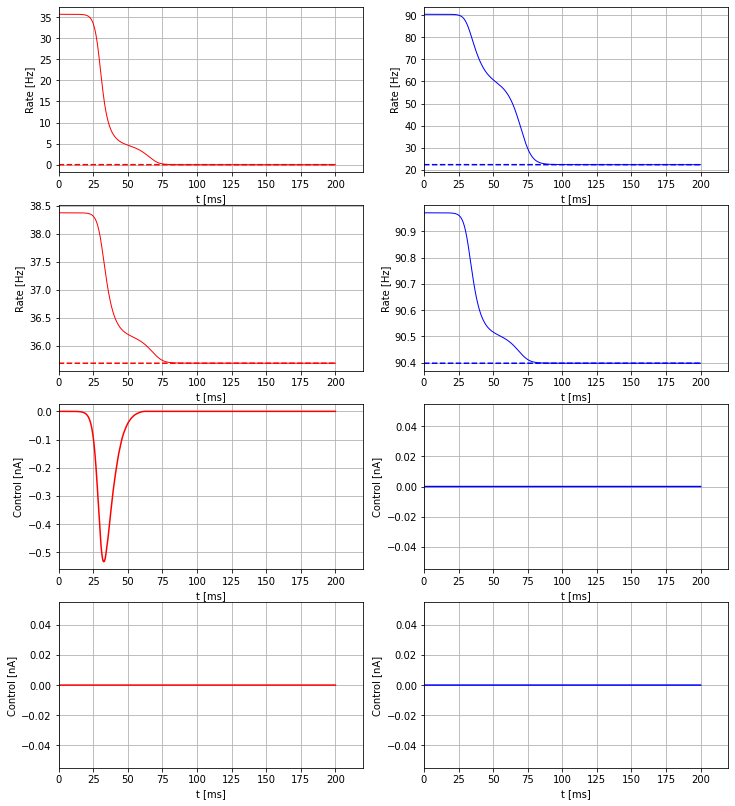

TASK :  4
TASK :  5
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
POINT :  [0.475, 0.6]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5


In [75]:
for m_ind in range(len(mu_ext)):
    print("POINT : ", mu_ext[m_ind])
    
    for c_ind in range(len(cmat_array)):
        print("CONNECTIVITY : ", cmat_array[c_ind])
        cmat = cmat_array[c_ind]
        
        for p_ind in range(len(p_var_array)):
            print("PRECISION MEASURE : ", p_var_array[p_ind])
            
            for t_ind in range(6):
                print("TASK : ", t_ind)
                
                if c_ind == 1 and t_ind > 1:
                    continue
                
                if type(optControl[m_ind][c_ind][p_ind][t_ind]) == type(None):
                    continue
                  
                if [m_ind, c_ind, p_ind, t_ind] != [0,0,1,3]:
                    continue

                aln = initmodel(mu_ext[m_ind][0], mu_ext[m_ind][1], cmat, dmat)
                max_it = int(0)
                limit = 1e-6
                
                print(optControl[m_ind][c_ind][p_ind][t_ind][1,1,::100])

                for l in range( optControl[m_ind][c_ind][p_ind][t_ind].shape[2] ):
                    if ( np.abs(optControl[m_ind][c_ind][p_ind][t_ind][0,0,l]) > limit
                        or np.abs(optControl[m_ind][c_ind][p_ind][t_ind][0,1,l]) > limit
                        or np.abs(optControl[m_ind][c_ind][p_ind][t_ind][1,0,l]) > limit
                        or np.abs(optControl[m_ind][c_ind][p_ind][t_ind][1,1,l]) > limit):
                        init_ind = l - n_pre
                        break
                        
                if init_ind == -1:
                    init_ind = 0

                print("init ind = ", init_ind)

                w_ = 1.
                aln.params.duration = dur
                cost.setParams(1., w_ * factor_we, w_ * factor_ws)
                weight[m_ind][c_ind][p_ind][t_ind] = cost.getParams()

                setinit(init_vars_array[m_ind][c_ind][p_ind][t_ind], N)

                control0 = aln.getZeroControl()
                if init_ind != 0:
                    control0[:,:,:-init_ind] = optControl[m_ind][c_ind][p_ind][t_ind][:,:,n_pre+init_ind:-n_post]
                else:
                    control0 = optControl[m_ind][c_ind][p_ind][t_ind][:,:,n_pre-1:-n_post+1]

                optControl[m_ind][c_ind][p_ind][t_ind], optState[m_ind][c_ind][p_ind][t_ind], c_, r_, g_, p_, costnode[m_ind][c_ind][p_ind][t_ind] = aln.A1(
                    control0, target_array[m_ind][c_ind][p_ind][t_ind], c_scheme, u_mat, u_scheme,
                    max_iteration_ = max_it, tolerance_ = tol, startStep_ = start_step,
                    max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
                    t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
                    prec_variables_ = p_var_array[p_ind], transition_time_ = trans_time)

                plot(optControl[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             optState[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             target_array[m_ind][c_ind][p_ind][t_ind])

In [77]:
with open(file_,'wb') as f:
    pickle.dump([optControl, optState, weight, costnode, w_init], f)

POINT :  [0.45, 0.475]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
set cost params:  1.0 0.0 1.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.5902933268358475
Gradient descend method:  None
RUN  1 , total integrated cost =  1.5902933268358475
Control only changes marginally.
RUN  1 , total integrated cost =  1.5902933268358475
Improved over  1  iterations in  40.262351976998616  seconds by  0.0  percent.
Final step size =  10.0
cost splitting :  1.4963025594929446e-06 [1.5902918 0.       ]
2001 200.10000000000002
(2001,) (2, 20, 2001)


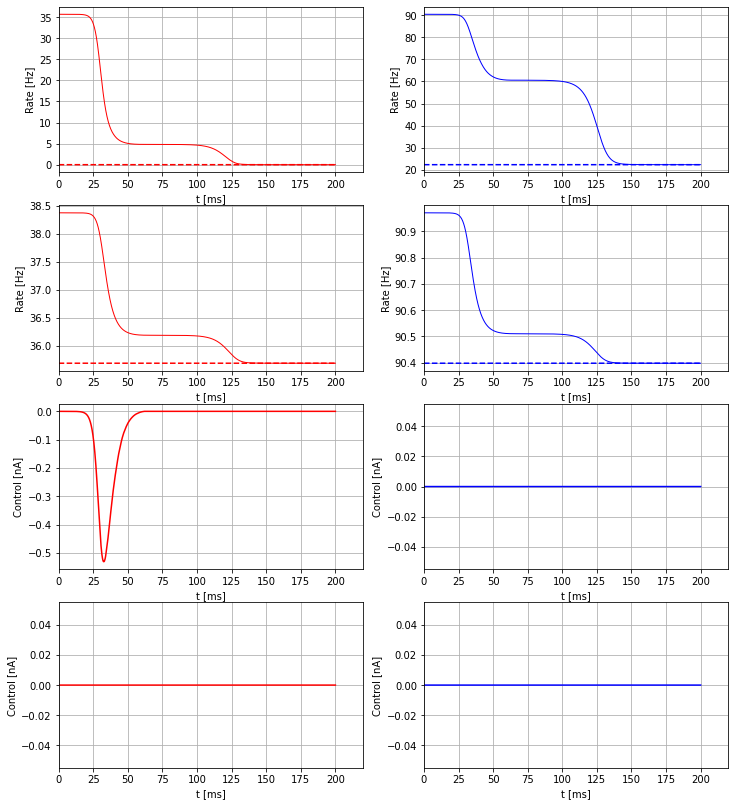

TASK :  4
TASK :  5
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
POINT :  [0.475, 0.6]
CONNECTIVITY :  [[0. 0.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
CONNECTIVITY :  [[0. 1.]
 [1. 0.]]
PRECISION MEASURE :  [[0 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5
PRECISION MEASURE :  [[1 0]
 [1 0]]
TASK :  0
TASK :  1
TASK :  2
TASK :  3
TASK :  4
TASK :  5


In [87]:
conv = [ [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                           [ [ None, None ], [ None, None ] ] ],
                      [ [ [ None, None, None, None, None, None ], [ None, None, None, None, None, None ] ],
                           [ [ None, None ], [ None, None ] ] ] ]

tol = 1e-12

for m_ind in range(len(mu_ext)):
    print("POINT : ", mu_ext[m_ind])
    
    for c_ind in range(len(cmat_array)):
        print("CONNECTIVITY : ", cmat_array[c_ind])
        cmat = cmat_array[c_ind]
        
        for p_ind in range(len(p_var_array)):
            print("PRECISION MEASURE : ", p_var_array[p_ind])
            
            for t_ind in range(6):
                print("TASK : ", t_ind)
                
                if c_ind == 1 and t_ind > 1:
                    continue
                    
                if [m_ind, c_ind, p_ind, t_ind] != [0,0,1,3]:
                    continue
                
                if type(optControl[m_ind][c_ind][p_ind][t_ind]) == type(None):
                    continue

                aln = initmodel(mu_ext[m_ind][0], mu_ext[m_ind][1], cmat, dmat)
    
                while not conv[m_ind][c_ind][p_ind][t_ind]:
                    max_it = int(10)

                    w_ = 1.
                    aln.params.duration = dur
                    cost.setParams(1., w_ * factor_we, w_ * factor_ws)
                    weight[m_ind][c_ind][p_ind][t_ind] = cost.getParams()

                    setinit(init_vars_array[m_ind][c_ind][p_ind][t_ind], N)

                    control0 = aln.getZeroControl()
                    control0 = optControl[m_ind][c_ind][p_ind][t_ind][:,:,n_pre:-n_post]

                    optControl[m_ind][c_ind][p_ind][t_ind], optState[m_ind][c_ind][p_ind][t_ind], c_, r_, g_, p_, costnode[m_ind][c_ind][p_ind][t_ind] = aln.A1(
                        control0, target_array[m_ind][c_ind][p_ind][t_ind], c_scheme, u_mat, u_scheme,
                        max_iteration_ = max_it, tolerance_ = tol, startStep_ = start_step,
                        max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
                        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = c_var,
                        prec_variables_ = p_var_array[p_ind], transition_time_ = trans_time)

                    if c_[2] == 0.:
                        conv[m_ind][c_ind][p_ind][t_ind] = True

                    print('cost splitting : ', costnode[m_ind][c_ind][p_ind][t_ind][0][0][0],
                          costnode[m_ind][c_ind][p_ind][t_ind][cost_index][0][:2])

                    if conv[m_ind][c_ind][p_ind][t_ind]:
                        plot(optControl[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             optState[m_ind][c_ind][p_ind][t_ind][:,:,100:-100],
                             target_array[m_ind][c_ind][p_ind][t_ind])

                    if np.abs(target_array[m_ind][c_ind][p_ind][t_ind][1,0,-1]
                              - optState[m_ind][c_ind][p_ind][t_ind][1,0,-1]) < 10.:
                        with open(file_,'wb') as f:
                            pickle.dump([optControl, optState, weight, costnode, w_init], f)
                    else:
                        print("converged to zero, reload and break")
                        if os.path.isfile(file_) :
                            print("file found")

                            with open(file_,'rb') as f:
                                load_array = pickle.load(f)

                                optControl = load_array[0]
                                optState = load_array[1]
                                weight = load_array[2]
                                costnode = load_array[3]
                                w_init = load_array[4]  
                        break